In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import skimage
import matplotlib.pyplot as plt
import imageio
import pylab
from glob import glob
import sys

In [2]:
data_paths = sorted(glob("./data/*"))

In [3]:
data_paths

['./data\\video_001.mp4', './data\\video_002.mp4']

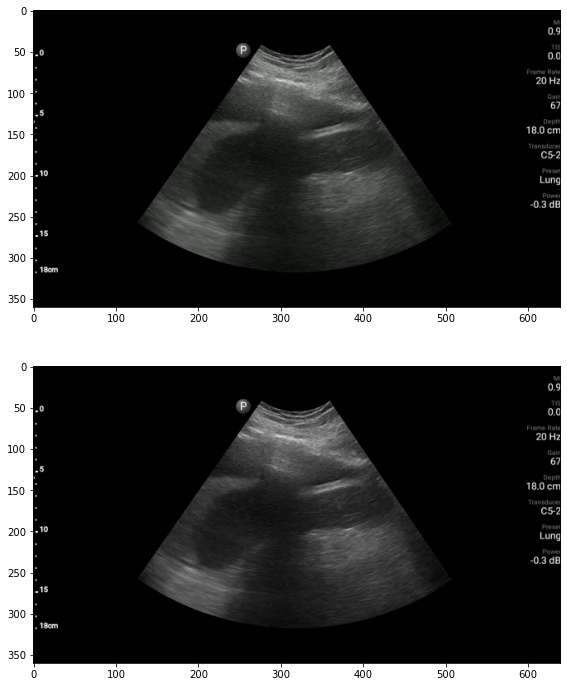

In [7]:
ims = np.zeros((2,360,640,3))

for i in range(len(data_paths)):
    vid = imageio.get_reader(data_paths[i], 'ffmpeg')
    ims[i] = vid.get_data(30)
    
ims = ims / 255

fig, axs = plt.subplots(2)
fig.set_size_inches(15,12)

axs[0].imshow(ims[1])

ocimg = np.mean(ims[1], axis=2)
axs[1].imshow(ocimg, cmap = 'gray')
plt.show()

In [8]:
!pip install imageio-ffmpeg

In [21]:
from skimage import measure

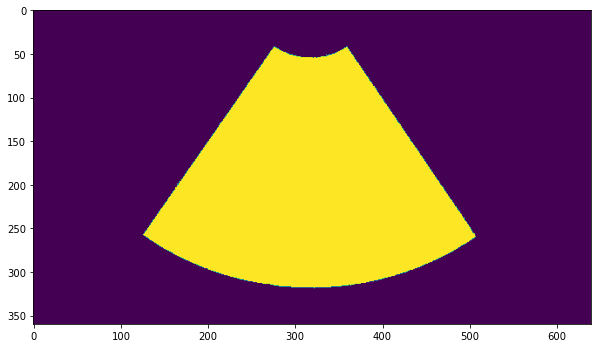

In [24]:
mask = ocimg > 0.006
labelled = skimage.measure.label(mask)
center = np.asarray(np.shape(ocimg)) // 2
num = labelled[center[0],center[1]]
plt.rcParams["figure.figsize"] = (10,15)
USmask = labelled == num
plt.imshow(USmask)
plt.show()

In [25]:
def get_rectilinear_resampling_map(mask, ray_density = 0.5, blur = 0.5):
#     mask is boolean array for US image
#     ray_density is number of rays per pixel in outer curve in US image
#     blur os variance of 2D gaussian used for weights

    try:
        assert(blur > 0)
    except:
        sys.exit("blur needs to be greater than zero")

    midline = np.shape(mask)[1] // 2 

    # get top left, top right, bottom left, bottom right "true" points of mask
    left_indices = np.asarray(np.where(mask[:,0:midline] == 1))
    right_indices = np.asarray(np.where(mask[:,midline:] == 1))

    tl = left_indices[:,np.argmin(left_indices[0])]
    tr = right_indices[:,np.argmin(right_indices[0])] + np.array([0,midline])
    bl = left_indices[:,np.argmin(left_indices[1])]
    br = right_indices[:,np.argmax(right_indices[1])] + np.array([0,midline])
    
    # get "center" point of circles in US image
    
    sl = (bl[1] - tl[1])/(bl[0]-tl[0])
    sr = (br[1] - tr[1])/(br[0]-tr[0])

    center_x = -((-sl* tl[0] + tl[1] + sr *tr[0] - tr[1])/(sl - sr)) 
    center_y = -((-sl* sr *tl[0] + sr* tl[1] + sl *sr *tr[0] - sl* tr[1])/(sl - sr))

    center = np.array([center_x, center_y])

    inner_radius = (np.linalg.norm(center - tl)+ np.linalg.norm(center - tr))/2
    outer_radius = (np.linalg.norm(center - bl)+ np.linalg.norm(center - br))/2

    radii = np.array([inner_radius, outer_radius])

    # determine total angle of the sector in the image

    left = np.linalg.norm(center - bl)
    right = np.linalg.norm(center - br)
    across = np.linalg.norm(bl - br)
    total_angle = np.arccos((left**2 + right**2 - across**2) / (2*left*right))

    # calculate bottom angle (angle of left side wrt midline)

    bottom_angle = np.arcsin((bl[1]-midline)/left)
    print(bottom_angle, "bottom angle in radians")
    top_angle = np.arcsin((br[1]-midline)/right)
    print(top_angle, "top angle in radians")

    # determine the x and y sizes of the resampled image
    # from ray density. y size will be sector depth

    target_xsize = int(ray_density*(outer_radius)*total_angle + 0.5) # arc length (pixels) times ray density
    target_ysize = int(outer_radius - inner_radius + 0.5) # depth of US image

    # create mapping tensor

    mapping = np.zeros([target_xsize, target_ysize, 11])

    thetas = np.linspace(bottom_angle, bottom_angle+total_angle, target_xsize)
    rads = np.linspace(inner_radius, outer_radius, target_ysize)

    for i in range(target_xsize):
        for j in range(target_ysize):
            
            theta = thetas[i]
            rad = rads[j]
            
            x = np.cos(theta)*rad + center_x
            y = np.sin(theta)*rad + center_y
            
            kernel_center_x = int(np.round(x))
            kernel_center_y = int(np.round(y))

            kernel_weights = np.zeros([3,3])

            G = multivariate_normal([x,y], np.eye(2)*blur)
            for i in range(3):
                for j in range(3):
                    i0 = kernel_center_x + i - 1
                    i1 = kernel_center_y + j - 1
                    if (mask[i0,i1]):
                        kernel_weights[i,j] = G.pdf([i0,i1])
                    else:
                        kernel_weights[i,j] = 0.0

            if (np.sum(kernel_weights) == 0):
                sys.exit("sum of kernel weights was 0")

            kernel_weights = kernel_weights / np.sum(kernel_weights)
            kernel_weights = kernel_weights.reshape(9)

            mapping[i,j] = np.concatenate(([kernel_center_x, kernel_center_y], kernel_weights))
        
    return mapping

## TODO

- normalize image dimensions to (0,1) in one axis for generalization to other images
- compute resampling
    - gaussian weights ?
    - ex. rectilinear image: 10,10 -> maps to 12.3, 15.75, middle pixel of kernel 12, 16
    - perhaps use fixed gaussian weights, perhaps calculate kernel weights per pixel
    - perhaps use ITKUltrasound -- convert physical point to continuous index could be helpful
    

In [26]:
curved_data = ocimg 
ray_density = 2/3 # number of rays per pixel in outer curve in US image
mask = USmask # mask for US image
blur = 0.5 # variance of 2D gaussian used for weights

try:
    assert(blur > 0)
except:
    sys.exit("blur needs to be greater than zero")

midline = np.shape(mask)[1] // 2 

# fig, axs = plt.subplots(1,2)
# fig.set_size_inches(12,15)
# axs[0].imshow(mask[:,0:midline])
# axs[1].imshow(mask[:,midline:])

left_indices = np.asarray(np.where(mask[:,0:midline] == 1))
right_indices = np.asarray(np.where(mask[:,midline:] == 1))

tl = left_indices[:,np.argmin(left_indices[0])]
tr = right_indices[:,np.argmin(right_indices[0])] + np.array([0,midline])
bl = left_indices[:,np.argmin(left_indices[1])]
br = right_indices[:,np.argmax(right_indices[1])] + np.array([0,midline])

# print(tl, tr, bl, br)

sl = (bl[1] - tl[1])/(bl[0]-tl[0])
sr = (br[1] - tr[1])/(br[0]-tr[0])

center_x = -((-sl* tl[0] + tl[1] + sr *tr[0] - tr[1])/(sl - sr)) 
center_y = -((-sl* sr *tl[0] + sr* tl[1] + sl *sr *tr[0] - sl* tr[1])/(sl - sr))

center = np.array([center_x, center_y])

inner_radius = (np.linalg.norm(center - tl)+ np.linalg.norm(center - tr))/2
outer_radius = (np.linalg.norm(center - bl)+ np.linalg.norm(center - br))/2

radii = np.array([inner_radius, outer_radius])

# determine total angle of the image

left = np.linalg.norm(center - bl)
right = np.linalg.norm(center - br)
across = np.linalg.norm(bl - br)
total_angle = np.arccos((left**2 + right**2 - across**2) / (2*left*right))

# calculate bottom angle (angle of left side wrt midline)

bottom_angle = np.arcsin((bl[1]-midline)/left)
print(bottom_angle, "bottom angle in radians")
top_angle = np.arcsin((br[1]-midline)/right)
print(top_angle, "top angle in radians")

# determine the x and y sizes of the resampled image

target_xsize = int(ray_density*(outer_radius)*total_angle + 0.5) # arc length (pixels) times ray density
target_ysize = int(outer_radius - inner_radius + 0.5) # depth of US image
print(total_angle*180/np.pi, "total calculated angle in degrees")
print(total_angle, "total calculated angle in radians")

print(target_xsize, target_ysize)

# create tensor to hold mapping and weights for resampling
# dimensions: (number of rays (pixels in x direction), pixels per ray (y direction), 
# third dimension is length 11: 2 coords of center of gaussian kernel in input image, 9 weights for 3x3 kernel)

# When calcuating output image, do the following algo
# start with angle theta and radius r
# convert to rectilinear coordinates: x, y
# choose the closest integers to x,y to be the 
#   the center of the 3x3 gaussian blurring kernel
# Take a gaussian G with mean x,y and variance "b" (blur)
# Take the likelihoods under G of the indices of the
#   3x3 kernel to be the weight of those components
#   but set any components outside of the mask to weight 0
# normalize the weights
# say xc, yc is the center of the kernel
# at the index (x_pixel, y_pixel) in the weights map
#   store x,y and the gaussian kernel weights (11 items)
# will be left with a (x_pixels,y_pixels,11) mapping tensor

mapping = np.zeros([target_xsize, target_ysize, 11])

thetas = np.linspace(bottom_angle, bottom_angle+total_angle, target_xsize)
rads = np.linspace(inner_radius, outer_radius, target_ysize)

for i in range(target_xsize):
    for j in range(target_ysize):
        j += 50 # using for testing
        i += 150
        
        theta = thetas[i]
        rad = rads[j]
#         print(theta, rad)
        x = np.cos(theta)*rad + center_x
        y = np.sin(theta)*rad + center_y
#         print(x,y)
        kernel_center_x = int(np.round(x))
        kernel_center_y = int(np.round(y))
                
        kernel_weights = np.zeros([3,3])
        
        G = multivariate_normal([x,y], np.eye(2)*0.4)
        for i in range(3):
            for j in range(3):
                i0 = kernel_center_x + i - 1
                i1 = kernel_center_y + j - 1
                if (mask[i0,i1]):
                    kernel_weights[i,j] = G.pdf([i0,i1])
                else:
                    kernel_weights[i,j] = 0.0
                    
        if (np.sum(kernel_weights) == 0):
            sys.exit("sum of kernel weights was 0")
        
        kernel_weights = kernel_weights / np.sum(kernel_weights)
        
        print(kernel_weights)
        
        kernel_weights = kernel_weights.reshape(9)
        
        mapping[i,j] = np.concatenate(([kernel_center_x, kernel_center_y], kernel_weights))
        
        print(mapping[i,j])
        
        
        break
    break

-0.6165578676223863 bottom angle in radians
0.5912579596831808 top angle in radians
69.1975647262653 total calculated angle in degrees
1.2077253388352183 total calculated angle in radians
270 262
[[0.03465749 0.11654766 0.03217168]
 [0.12014831 0.40403973 0.11153066]
 [0.03419022 0.11497631 0.03173793]]
[1.05000000e+02 3.25000000e+02 3.46574946e-02 1.16547665e-01
 3.21716831e-02 1.20148308e-01 4.04039728e-01 1.11530661e-01
 3.41902242e-02 1.14976308e-01 3.17379277e-02]


# Define the functions


In [27]:
def get_rectilinear_resampling_map(mask, ray_density = 0.5, blur = 0.5):
#     mask is boolean array for US image
#     ray_density is number of rays per pixel in outer curve in US image
#     blur os variance of 2D gaussian used for weights

    try:
        assert(blur > 0)
    except:
        sys.exit("blur needs to be greater than zero")

    midline = np.shape(mask)[1] // 2 

    # get top left, top right, bottom left, bottom right "true" points of mask
    left_indices = np.asarray(np.where(mask[:,0:midline] == 1))
    right_indices = np.asarray(np.where(mask[:,midline:] == 1))

    tl = left_indices[:,np.argmin(left_indices[0])]
    tr = right_indices[:,np.argmin(right_indices[0])] + np.array([0,midline])
    bl = left_indices[:,np.argmin(left_indices[1])]
    br = right_indices[:,np.argmax(right_indices[1])] + np.array([0,midline])
    
    # get "center" point of circles in US image

    center_x = -((-sl* tl[0] + tl[1] + sr *tr[0] - tr[1])/(sl - sr)) 
    center_y = -((-sl* sr *tl[0] + sr* tl[1] + sl *sr *tr[0] - sl* tr[1])/(sl - sr))

    center = np.array([center_x, center_y])

    inner_radius = (np.linalg.norm(center - tl)+ np.linalg.norm(center - tr))/2
    outer_radius = (np.linalg.norm(center - bl)+ np.linalg.norm(center - br))/2

    radii = np.array([inner_radius, outer_radius])

    # determine total angle of the sector in the image

    left = np.linalg.norm(center - bl)
    right = np.linalg.norm(center - br)
    across = np.linalg.norm(bl - br)
    total_angle = np.arccos((left**2 + right**2 - across**2) / (2*left*right))

    # calculate bottom angle (angle of left side wrt midline)

    bottom_angle = np.arcsin((bl[1]-midline)/left)
    top_angle = np.arcsin((br[1]-midline)/right)

    # determine the x and y sizes of the resampled image
    # from ray density. y size will be sector depth

    target_xsize = int(ray_density*(outer_radius)*total_angle + 0.5) # arc length (pixels) times ray density
    target_ysize = int(outer_radius - inner_radius + 0.5) # depth of US image

    # create mapping tensor

    mapping = np.zeros([target_ysize, target_xsize, 11])

    thetas = np.linspace(bottom_angle, bottom_angle+total_angle, target_xsize + 2)
    rads = np.linspace(inner_radius, outer_radius, target_ysize + 2)

    for i in range(target_xsize):
        for j in range(target_ysize): 
            
            theta = thetas[i + 1]
            rad = rads[j + 1]
            
            x = np.cos(theta)*rad + center_x
            y = np.sin(theta)*rad + center_y
            
            kernel_center_x = int(np.round(x))
            kernel_center_y = int(np.round(y))

            kernel_weights = np.zeros([3,3])

            G = multivariate_normal([x,y], np.eye(2)*blur)
            for m in range(3):
                for n in range(3):
                    i0 = kernel_center_x + m - 1
                    i1 = kernel_center_y + n - 1
                    if (mask[i0,i1]):
                        kernel_weights[m,n] = G.pdf([i0,i1])
                    else:
                        kernel_weights[m,n] = 0.0

            if (np.sum(kernel_weights) == 0):
                print(i,j, "ij")
                print(kernel_center_x, kernel_center_y, "kc")
                sys.exit("sum of kernel weights was 0")

            kernel_weights = kernel_weights / np.sum(kernel_weights)
            kernel_weights = kernel_weights.reshape(9)

            mapping[j,i] = np.concatenate(([kernel_center_x, kernel_center_y], kernel_weights))
        
    return mapping

In [28]:
img_mapping = get_rectilinear_resampling_map(mask, ray_density = 2/3, blur = 0.4)

In [29]:
def get_resampled_image_from_mapping(image, mapping):
    # image is the original 2D image to be resampled
    # mapping is the mapping tensor generated by get_rectilinear_resampling_map
    
    if (len(np.shape(image))!=2):
        sys.exit("image is not 2D--must be 2D")
    
    dims = np.shape(mapping)[:2]
    res = np.zeros(dims)
    
    for i in range(dims[0]):
        for j in range(dims[1]):
            meta = mapping[i,j]
            kcx, kcy = meta[:2]
            kcx, kcy = int(kcx), int(kcy)
            kernel_weights = meta[2:]
            kernel_weights = np.reshape(kernel_weights, (3,3))
            window = image[kcx-1:kcx+2,kcy-1:kcy+2]
            try:
                val = np.sum(np.multiply(window, kernel_weights))
            except:
                print(kcx, kcy, "kernel center coords")
                print(np.shape(window), "window shape")
                print(np.shape(kernel_weights), "kernel shape")
                print(window)
                print(kernel_weights)
                sys.exit("couldn't do kernel multiply")
            res[i,j] = val

    return res

resampled_img = get_resampled_image_from_mapping(ocimg, img_mapping)

In [30]:
def get_US_mask_from_image(image):
    mask = image > 0.006
    labelled = skimage.measure.label(mask)
    center = np.asarray(np.shape(image)) // 2
    num = labelled[center[0],center[1]]
    USmask = labelled == num
    return USmask

In [31]:
from scipy.stats import mode


In [32]:
np.unique(resampled_img)

array([0.0130719 , 0.01710399, 0.02140042, ..., 0.80761322, 0.80946364,
       0.8099981 ])

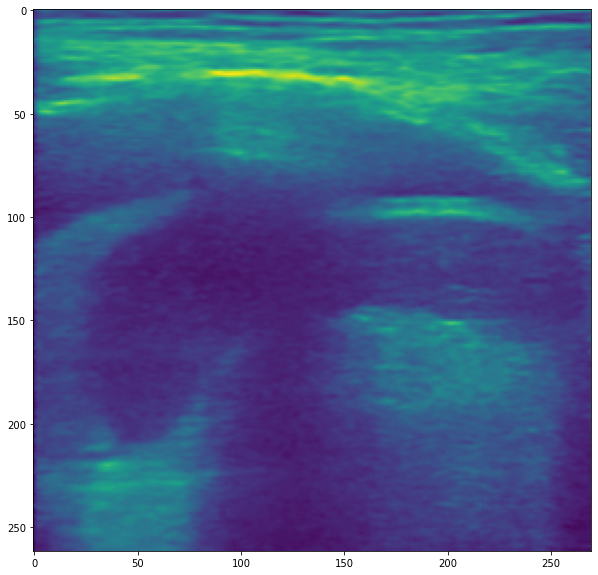

In [33]:
plt.imshow(resampled_img)

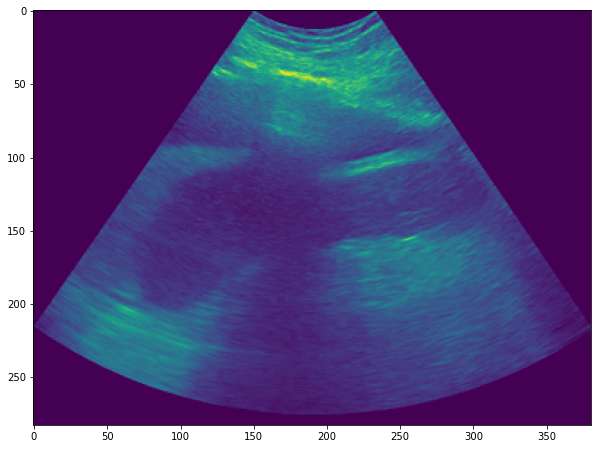

In [34]:
top = np.min([tl[0], tr[0]])
left = bl[1]
right = br[1]
bottom = 325

masked_ocimg = np.zeros(np.shape(ocimg))
masked_ocimg[mask] = ocimg[mask]
cropped_ocimg = masked_ocimg[top:bottom, left:right]
plt.imshow(cropped_ocimg)

## Actual Example of code

In [35]:
mask = get_US_mask_from_image(ocimg)
img_mapping = get_rectilinear_resampling_map(mask, ray_density = 2/3, blur = 0.3)
resampled_img = get_resampled_image_from_mapping(ocimg, img_mapping)

<function unique at 0x00000194DC1338B0>


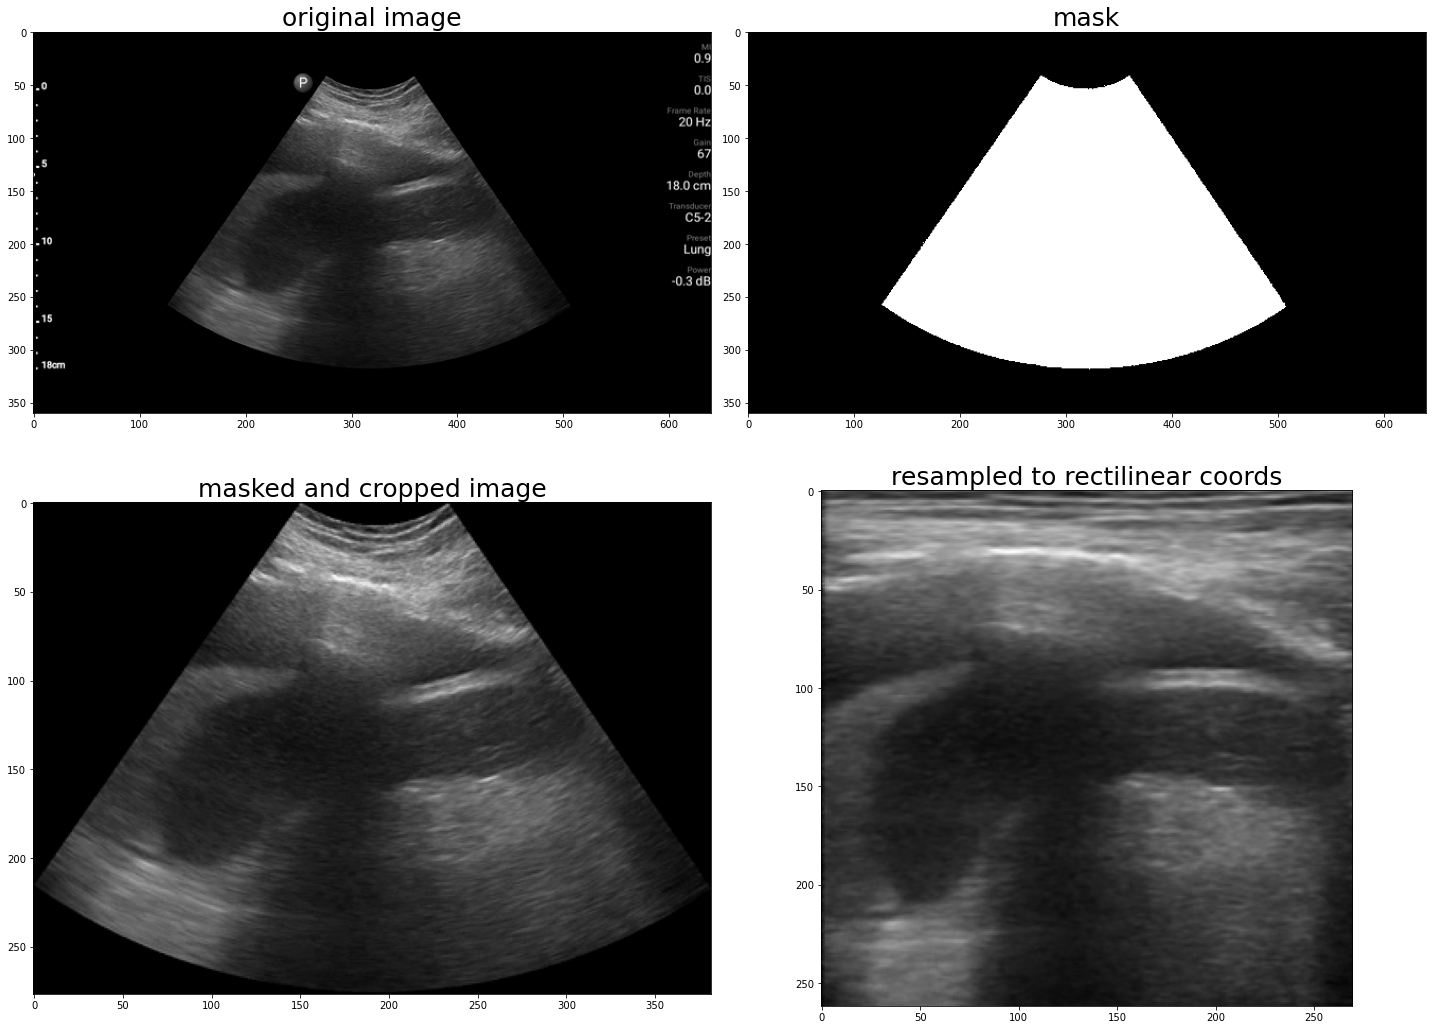

In [36]:
print(np.unique)
masked_img = np.zeros(np.shape(ocimg))
masked_img[mask] = ocimg[mask]

true_points = np.argwhere(masked_img)
top_left = true_points.min(axis=0)
bottom_right = true_points.max(axis=0)
cropped_masked_img = masked_img[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
          top_left[1]:bottom_right[1]+1]

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20,15)
axs[0,0].imshow(ocimg, cmap='gray')
axs[0,1].imshow(mask, cmap='gray')
axs[1,0].imshow(cropped_masked_img, cmap='gray')
axs[1,1].imshow(resampled_img, cmap='gray')

axs[0,0].set_title("original image", fontsize = 25)
axs[0,1].set_title("mask", fontsize = 25)
axs[1,0].set_title("masked and cropped image", fontsize = 25)
axs[1,1].set_title("resampled to rectilinear coords", fontsize = 25)

plt.tight_layout()